In [1]:
import random
from collections import defaultdict

import gym
import gym.spaces as spaces
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator
import pandas as pd
import torch   
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam    
from torch.utils.data import DataLoader, Dataset
import stable_baselines3 as sb3

from envs.robots.robot_arm import RobotArm
from supervised.data import \
    TargetGaussianDataset as SupervisedTargetGaussianDataset
from supervised.data import YMode
from supervised.loss import PointDistanceLoss, IKLoss
from supervised.utils import forward_kinematics
from vae.data.load_data_set import TargetGaussianDataset

In [2]:
n_joints = 5
device = "cuda:0"

In [3]:
df_start = pd.read_csv(f"datasets/{n_joints}/train/state_IK_random_start.csv")
df_action = pd.read_csv(f"datasets/{n_joints}/train/actions_IK_random_start.csv")

In [4]:
class WrapperDataset(Dataset):
    def __init__(self, path, supervised=True) -> None:
        if supervised:
            self.data = SupervisedTargetGaussianDataset(path, 0.2)
        else:
            self.data = TargetGaussianDataset(path, 0.2)
        self.supervised = supervised

    def __getitem__(self, idx):
        if self.supervised:
            x, y = self.data[idx]
            x = x.detach()
            return x, y

        x, cond_enc, cond_dec, y = self.data[idx]
        x = torch.cat([x, cond_enc.detach()])
        # x: delta to target, curr pos, curr angles
        return x, y
    
    def __len__(self):
        return len(self.data)
    

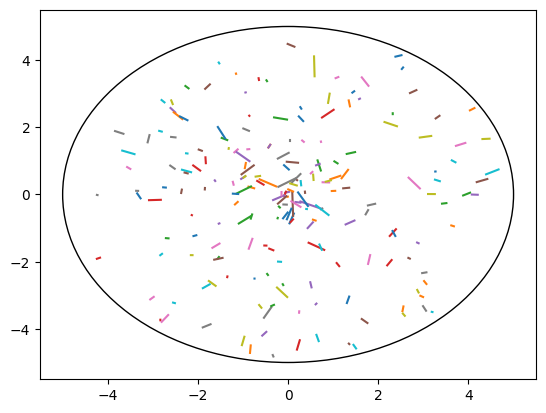

In [5]:
dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv", supervised=True)

fig, axs = plt.subplots()
axs.add_patch(plt.Circle((0, 0), n_joints, fill=False))
for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4]
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    plt.plot(data[:, 0], data[:, 1])

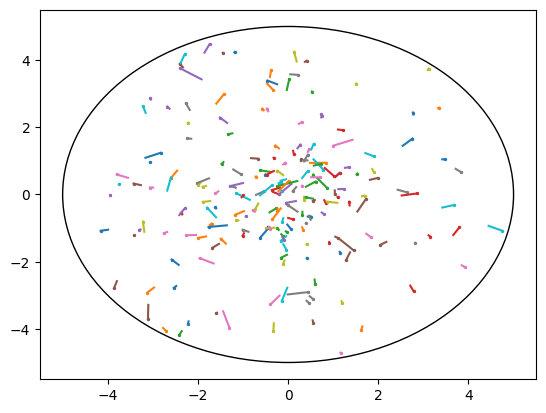

In [6]:
dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv", supervised=False)

fig, axs = plt.subplots()
axs.add_patch(plt.Circle((0, 0), n_joints, fill=False))
for x, y in random.choices(dataset, k=200):
    curr_pos = x[2: 4].detach()
    target_pos = y.detach()
    data = np.stack([curr_pos, target_pos])
    axs.plot(data[:, 0], data[:, 1])
    axs.scatter(curr_pos[0], curr_pos[1], s=2)

##### Question: What is happening in the plot above?

Because there is an implementation error to correct noise which lies outside the robots reach. Fixed in the latest version of the supervised dataset version

In [7]:
model = nn.Sequential(
    nn.Linear(4 + n_joints, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, n_joints),
).to(device)
optim = Adam(model.parameters(), lr=0.0003)

In [11]:
EPOCHS = 100
train_dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv")
train_loader = DataLoader(train_dataset, 32)
val_dataset = WrapperDataset(f"datasets/{n_joints}/val/state_IK_random_start.csv")
val_loader = DataLoader(val_dataset, 256)



def loss_fn(angles, y):
    pos = forward_kinematics(angles)[:, -1]
    return F.huber_loss(pos, y)

# loss_fn = PointDistanceLoss("cpu")

# loss_fn = IKLoss(0, 1, 0, YMode.POSITION)

stats = defaultdict(list)
                

for idx in range(EPOCHS):
    train_losses = []

    for x, y in train_loader:
        x = x.to(device)
        angles = x[:, 4:] + torch.tanh(model(x)) 
        loss = loss_fn(angles, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    with torch.no_grad():
        stats["val_loss"].append(np.mean([loss_fn(x[:, 4:].to(device) + torch.tanh(model(x.to(device))), y) for x, y in val_loader]))
    stats["train_loss"].append(np.mean(train_losses))

    if idx % 10 == 0:
        print("train loss: ", stats["train_loss"][-1], "val_loss: ", stats["val_loss"][-1])


train loss:  0.005288460519545661 val_loss:  0.0044385204
train loss:  0.0008002336833629007 val_loss:  0.00090119813
train loss:  0.0004977578166708612 val_loss:  0.0006482535
train loss:  0.0003079997995156444 val_loss:  0.00054321135
train loss:  0.00023365288100390586 val_loss:  0.00045461702
train loss:  0.000178439211234794 val_loss:  0.0003416491
train loss:  0.00014457152462510477 val_loss:  0.00028026075
train loss:  0.00011726483195341719 val_loss:  0.000255392
train loss:  9.963545874717048e-05 val_loss:  0.00022694116
train loss:  9.42210209612272e-05 val_loss:  0.00022879311


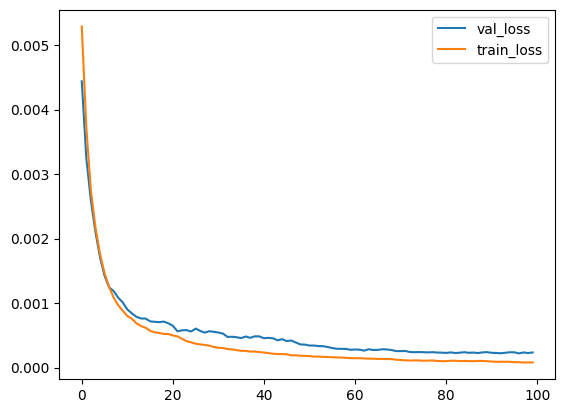

In [12]:
plt.plot(stats["val_loss"], label="val_loss")
plt.plot(stats["train_loss"], label="train_loss")
plt.legend()

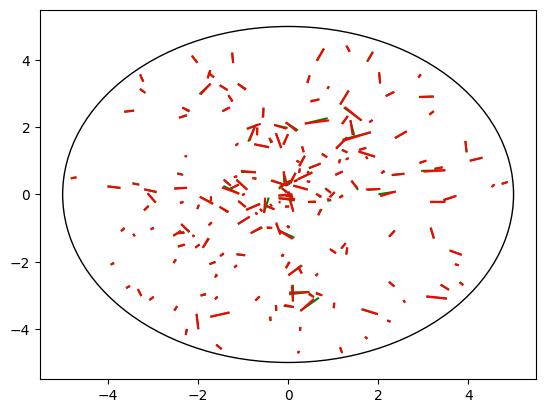

In [18]:
dataset = WrapperDataset(f"datasets/{n_joints}/train/state_IK_random_start.csv")

fig, axs = plt.subplots()
axs.add_patch(plt.Circle((0, 0), n_joints, fill=False))
for x, y in random.choices(dataset, k=200):
    x = x.to(device)
    with torch.no_grad():
        pred = (x[4:] + torch.tanh(model(x)))[None, :]

    model_pos = forward_kinematics(pred)[0, -1]
    curr_pos = x[2: 4].cpu()
    target_pos = y
    data = np.stack([curr_pos, target_pos])
    data_pred = np.stack([curr_pos, model_pos])
    axs.plot(data[:, 0], data[:, 1], color="green", label="ground truth")
    axs.plot(data_pred[:, 0], data_pred[:, 1], color="red", label="pred")
    

### RL Env

In [19]:


def sample_pt(rng: Generator, n: int):
    phi = rng.uniform(0, 2 * np.pi)
    scale = rng.uniform(0, n)
    return np.array([scale * np.cos(phi), scale * np.sin(phi), 1])

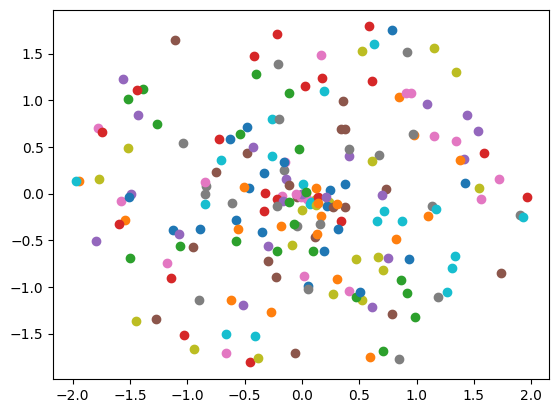

In [20]:
rng = np.random.default_rng(0)

for _ in range(200):
    plt.scatter(*sample_pt(rng, 2)[: 2])

In [21]:


# label_angles, _, _, _ = IK(
#     new_target,
#     np.rad2deg(state_angles[state_idx]).copy(),
#     np.ones_like(state_angles[state_idx]),
#     err_min=0.001)

arm = RobotArm(2)
target = sample_pt(rng, 2)
print(arm.end_position)
arm.IK(target, error_min=0.001)
print(arm.end_position)
print(target)

[2. 0.]
[0.55535459 1.79076648]
[0.55530158 1.79173216 1.        ]


In [24]:
class Army(gym.Env):
    def __init__(self, n=2, model=None):
        super().__init__()
        self.n = n
        self.model = model
        self.eps = 0.1
        self.max_steps = 100

        self.rng = np.random.default_rng(0)
        self.arm = RobotArm(n)
        self.target_pos = None
        self.curr_step = 0

        dim = 4 + self.n
        self.observation_space = spaces.Box(np.full(dim, -np.inf), np.full(dim, np.inf))
        cons = np.array([0.3, 0.3])
        self.action_space = spaces.Box(-cons, cons)

    def seed(self, seed: int = 0):
        self.rng = np.random.default_rng(seed)

    def obs(self):
        return np.concatenate(
            [self.target_pos[:2], self.arm.positions[-1], self.arm.angles]
        )

    def reset(self):
        start_pos = sample_pt(self.rng, self.arm.n_joints)
        arm.IK(start_pos, error_min=0.001)
        self.target_pos = sample_pt(self.rng, self.arm.n_joints)
        self.curr_step = 0
        return self.obs()

    def step(self, action):
        obs = np.concatenate([action, self.obs()[2:]])
        obs = torch.from_numpy(obs)[None, :].float()
        state_angles = obs[0, 4:]
        with torch.no_grad():
            angle = state_angles + torch.tanh(self.model(obs)[0]).numpy()

        self.arm.set(angle)
        distance = np.linalg.norm(self.target_pos[:2] - self.arm.end_position)
        done = True if distance < self.eps else False

        self.curr_step += 1
        if self.curr_step == self.max_steps:
            done = True

        return self.obs(), -distance, done, {}

    def render(self, fig=None, ax=None, color="k"):
        if fig is None or ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.set_xlim([- self.n -0.2, self.n + 0.2])
        ax.set_ylim([- self.n -0.2, self.n + 0.2])
        ax.scatter(*self.target_pos[:2])

        for p1, p2 in zip(self.arm.positions, self.arm.positions[1:]):
            data = np.stack([p1, p2])
            ax.plot(data[:, 0], data[:, 1], color=color, marker=".", alpha=2 / 5)

        return fig, ax

    def direction(self, max_length=0.4):
        delta = self.target_pos[:2] - self.arm.end_position
        norm = np.linalg.norm(delta, 2)
        scaling = 1 if norm < max_length else max_length / norm
        return scaling * delta

/home/uhrich/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


-4.44259858663229 False
-3.7192678657584843 False
-2.9278263108112577 False
-2.3922178454303866 False
-2.2915441790916002 False
-2.528829311078453 False
-2.8325458903981313 False
-3.0778358578036515 False
-3.2514046298300374 False
-3.308529730334217 False
-3.21753885197275 False
-2.973037248334515 False
-2.5862588726049354 False
-2.068320366102455 False
-1.5607133850724448 False
-1.261846380244829 False
-1.1091037300777855 False
-0.9876405197371056 False
-0.865956667040711 False
-0.736416391195826 False
-0.5990997688518914 False
-0.4613971180361145 False
-0.3281952849692442 False
-0.2051779684386301 False
-0.12073750036036318 False
-0.057205599504073903 True


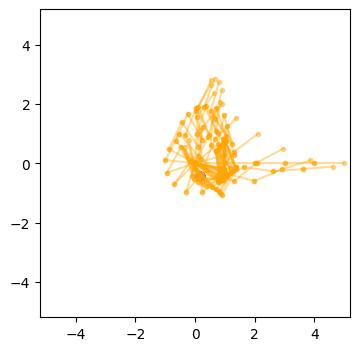

In [25]:
seed = 2

color = "orange"

env = Army(model=model.to("cpu"), n=n_joints)
env.seed(seed)
obs = env.reset()
fig, ax = env.render(color=color)
done = False

rewards = []
for _ in range(50):
    direction = env.direction()
    obs, reward, done, info = env.step(direction)
    print(reward, done)
    rewards.append(reward)
    env.render(fig, ax, color=color)

    if done:
        break

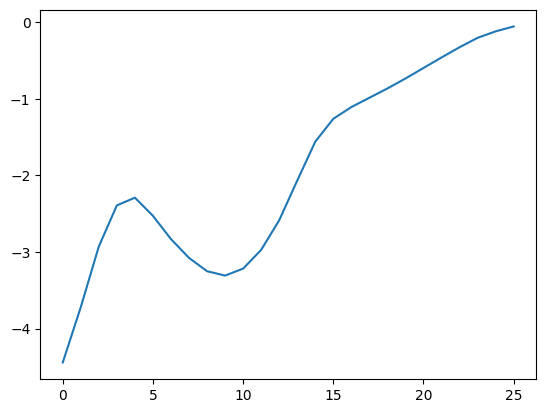

In [26]:
plt.plot(rewards)

In [27]:
alg = sb3.SAC("MlpPolicy", env, verbose=1)
alg.learn(20000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -228     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 25       |
|    time_elapsed    | 15       |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 0.0514   |
|    ent_coef        | 0.914    |
|    ent_coef_loss   | -0.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -338     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 23       |
|    time_elapsed    | 33       |
|    total_timesteps | 800      |
| train/             

/home/uhrich/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


-4.584953362843265 False
-4.098135112293725 False
-3.5254862050597984 False
-2.923059464432391 False
-2.3239033196563357 False
-1.7903044931181282 False
-1.2403764545412272 False
-0.7671733762394818 False
-0.4835363875310651 False
-0.5560335363077549 False
-0.8364065849366558 False
-1.0226335954017092 False
-1.2070547965748981 False
-1.365793200271024 False
-1.375023025039618 False
-1.4500357463218365 False
-1.5590218598416121 False
-1.56616300846742 False
-1.6105089064552873 False
-1.6061342006083192 False
-1.6420933199436143 False
-1.6316850002907266 False
-1.5060759528817813 False
-1.3823613910641894 False
-1.289782871093668 False
-1.1474223309268317 False
-1.0525571280888577 False
-0.838259739799683 False
-0.6388835213784158 False
-0.5072643428789859 False
-0.29305521548430374 False
-0.2589992305469897 False
-0.27891227804937124 False
-0.22696595217191157 False
-0.18635635404995443 False
-0.30763820969596134 False
-0.29117300538968277 False
-0.3104768564308345 False
-0.272667087650

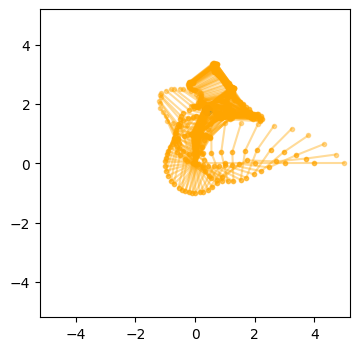

In [37]:
seed = 25
color = "orange"

env = Army(model=model, n=n_joints)
env.seed(seed)
obs = env.reset()
fig, ax = env.render(color=color)
done = False

rewards = []
for _ in range(100):
    direction, _ = alg.policy.predict(obs)
    # print(direction)
    obs, reward, done, info = env.step(direction)
    print(reward, done)
    env.render(fig, ax, color=color)
    rewards.append(reward)
    if done:
        break

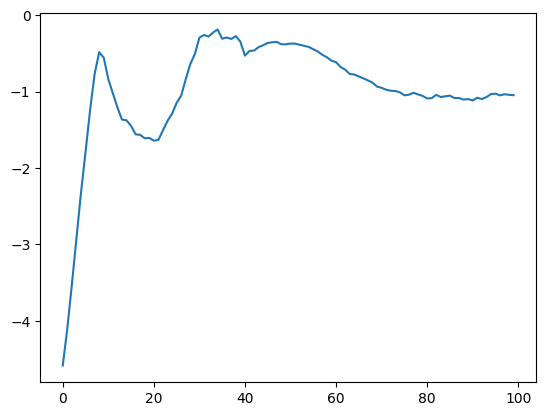

In [38]:
plt.plot(rewards)